In [1]:
"""
Testing memorization in VAR.

Settings: We have a subset of training data points (e.g., 5000 images from ImageNet train set).

1) mean activation of a neuron on a given training data point = expected activation of that neuron when the model is fed that data point multiple times with different augmentations.
2) 
"""

'\nTesting memorization in VAR.\n\nSettings: We have a subset of training data points (e.g., 5000 images from ImageNet train set).\n\n1) mean activation of a neuron on a given training data point = expected activation of that neuron when the model is fed that data point multiple times with different augmentations.\n2) \n'

In [20]:
import torch
import os
import sys
PROJECT_ROOT = os.path.abspath("../..")
sys.path.insert(0, PROJECT_ROOT)

print("Project root:", PROJECT_ROOT)

import matplotlib.pyplot as plt
import numpy as np

Project root: /BS/scene_repre/work/VAR


In [3]:
unit_mem_file = PROJECT_ROOT + "/unitmem_scores_corrected_abs.pt"
unit_mem_dict = torch.load(unit_mem_file)

In [4]:
print(unit_mem_dict.keys())  # Print the keys to see available layers

# total count of neurons
total_neurons = 0
for key in unit_mem_dict.keys():
    for block in range(len(unit_mem_dict[key])):
        for scale in range(10):
            C = unit_mem_dict[key][block][scale].shape[0]
            total_neurons += C

print("Total neurons across all layers:", total_neurons)

dict_keys(['fc1', 'fc1_act', 'fc2', 'q', 'k', 'v', 'attn_proj'])
Total neurons across all layers: 2129920


In [5]:
fc1_act = unit_mem_dict['fc1_act']  # Example for fc1 layer

In [6]:
print(len(fc1_act), len(fc1_act[0]), fc1_act[0][0].shape)  # Should print 16 and 10

16 10 torch.Size([4096])


In [7]:

all_unitmem = []  # list of (score, key, block, scale, unit)

# loop over keys "['fc1', 'fc1_act', 'fc2', 'q', 'k', 'v', 'attn_proj']" and 
# their corresponding values, which are lists of blocks. e.g. first iteration is: fc1, [block0, block1, ..., block15]
# second iteration is: fc1_act, [block0, block1, ..., block15], etc.
for key, blocks in unit_mem_dict.items():
    
    # Loop over blocks, e.g. block0, block1, ..., block15
    for block in range(len(blocks)):

        # Loop over scales, e.g. scale0, scale1, ..., scale9
        for scale in range(len(blocks[block])):
            unitmem_vec = blocks[block][scale]  # (C,)
            for unit in range(unitmem_vec.shape[0]):
                all_unitmem.append(
                    (unitmem_vec[unit].item(), key, block, scale, unit)
                )


In [8]:
# x[0] represents the unitmem score for a certain unit (neuron)
scores = torch.tensor([x[0] for x in all_unitmem])
print(scores.shape)  # Should print (num_units,)
threshold = torch.quantile(scores, 0.9)
print("UnitMem 90% threshold:", threshold.item())


torch.Size([2129920])
UnitMem 90% threshold: 0.45887312293052673


In [9]:
top_mem_neurons = [
    entry for entry in all_unitmem if entry[0] >= threshold
]

print(f"Number of top 10% neurons: {len(top_mem_neurons)}")


Number of top 10% neurons: 212993


In [10]:
for x in top_mem_neurons[:10]:
    print(
        f"UnitMem={x[0]:.4f}, layer={x[1]}, block={x[2]}, scale={x[3]}, unit={x[4]}"
    )


UnitMem=0.6920, layer=fc1, block=0, scale=0, unit=1
UnitMem=0.5282, layer=fc1, block=0, scale=0, unit=3
UnitMem=0.6036, layer=fc1, block=0, scale=0, unit=4
UnitMem=0.7171, layer=fc1, block=0, scale=0, unit=6
UnitMem=0.6857, layer=fc1, block=0, scale=0, unit=8
UnitMem=0.5667, layer=fc1, block=0, scale=0, unit=9
UnitMem=0.6073, layer=fc1, block=0, scale=0, unit=15
UnitMem=0.6444, layer=fc1, block=0, scale=0, unit=16
UnitMem=0.5744, layer=fc1, block=0, scale=0, unit=21
UnitMem=0.6562, layer=fc1, block=0, scale=0, unit=23


In [11]:
def plot_unitmem_sum_heatmap(unit_mem_dict, layer, save_path=None):
    """
    Plot a heatmap showing the SUM of UnitMem scores per block and scale
    for a given layer (e.g. fc1).

    Parameters
    ----------
    unit_mem_dict : dict
        unit_mem_dict[layer][block][scale] -> Tensor (C,)
    layer : str
        Layer name to plot (e.g. "fc1")
    save_path : str or None
        If provided, saves the figure to this path
    """

    blocks = unit_mem_dict[layer]
    num_blocks = len(blocks)
    num_scales = len(blocks[0])

    # heatmap[b, s] = sum_u UnitMem(u) at (block=b, scale=s)
    heatmap = torch.zeros(num_blocks, num_scales)

    for b in range(num_blocks):
        for s in range(num_scales):
            unitmem_scores = blocks[b][s]     # (C,)
            heatmap[b, s] = unitmem_scores.sum()

    # convert to numpy for plotting
    heatmap = heatmap.cpu().numpy()

    # ---- Plot ----
    plt.figure(figsize=(6, 5))
    im = plt.imshow(
        heatmap,
        origin="lower",      # block 0 at bottom
        aspect="auto",
        cmap="YlGnBu"
    )

    plt.colorbar(im, label="Sum of UnitMem scores")
    plt.xlabel("Scales")
    plt.ylabel("Blocks")
    plt.title(f"Sum of UnitMem per block and scale ({layer})")

    plt.xticks(range(num_scales))
    plt.yticks(range(num_blocks))

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=200)

    plt.show()

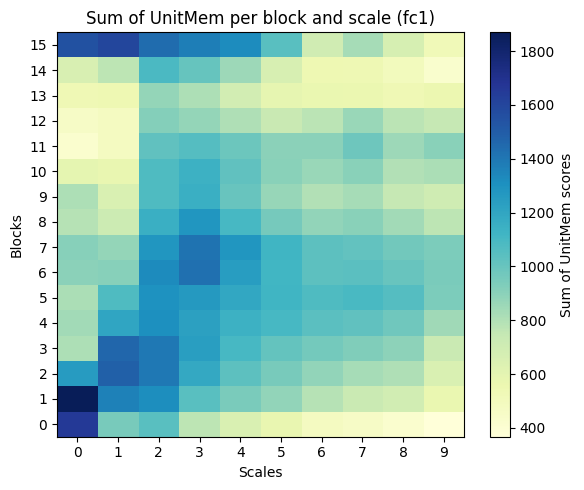

In [12]:
plot_unitmem_sum_heatmap(
    unit_mem_dict=unit_mem_dict,
    layer="fc1",
    save_path="unitmem_sum_fc1.png"
)


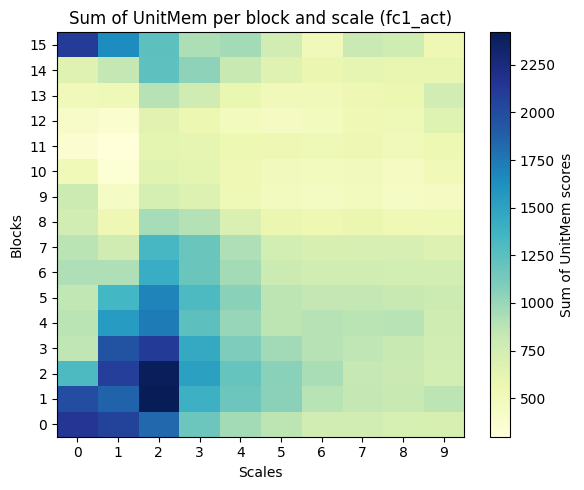

In [13]:
plot_unitmem_sum_heatmap(
    unit_mem_dict=unit_mem_dict,
    layer="fc1_act",
    save_path="unitmem_sum_fc1_act.png"
)

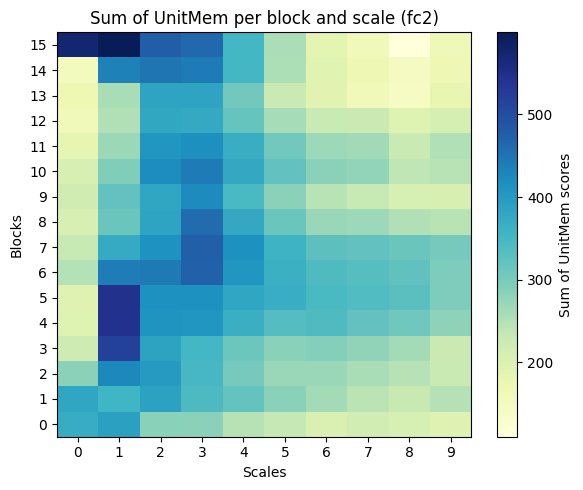

In [14]:
plot_unitmem_sum_heatmap(
    unit_mem_dict=unit_mem_dict,
    layer="fc2",
    save_path="unitmem_sum_fc2.png"
)

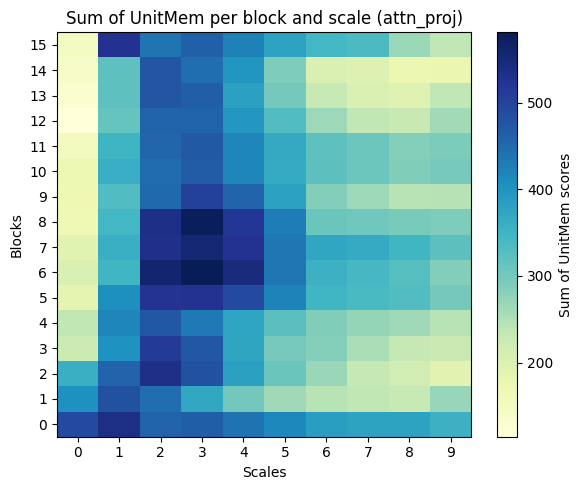

In [15]:
plot_unitmem_sum_heatmap(
    unit_mem_dict=unit_mem_dict,
    layer="attn_proj",
    save_path="unitmem_sum_attn_proj.png"
)

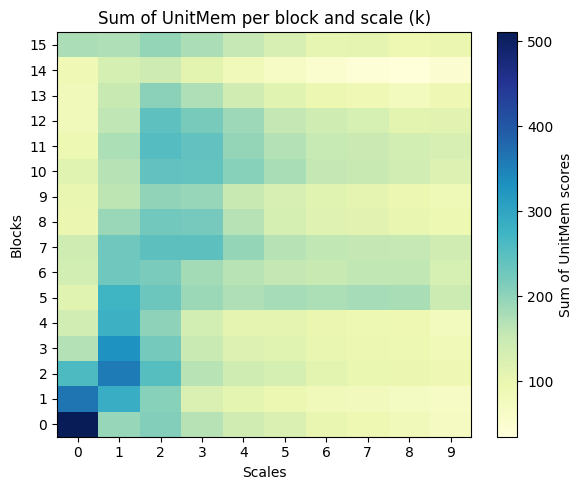

In [16]:
plot_unitmem_sum_heatmap(
    unit_mem_dict=unit_mem_dict,
    layer="k",
    save_path="unitmem_sum_k.png"
)

In [21]:
# Verify s-1-only attention mask rows per scale
import torch, os, sys
from models import build_vae_var

# Build a lightweight VAR on CPU (no checkpoint needed for mask)
device = "cpu"
patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)
_, var = build_vae_var(
    device=device,
    patch_nums=patch_nums,
    depth=16,
    shared_aln=False,
    attn_l2_norm=True,
    flash_if_available=False,
    fused_if_available=False,
)

begin_ends = var.begin_ends
mask = var.attn_bias_for_masking[0, 0]  # (L, L) with 0 for allowed, -inf for disallowed

ok = True
per_scale_counts = {}
for s, (bg, ed) in enumerate(begin_ends):
    expected = (patch_nums[s-1] ** 2) if s > 0 else (patch_nums[0] ** 2)
    counts = []
    for q in range(bg, ed):
        cnt = int(torch.isfinite(mask[q]).sum().item())
        counts.append(cnt)
        if cnt != expected:
            ok = False
            print(f"Mismatch: scale={s}, query_idx={q-bg} allowed={cnt}, expected={expected}")
    per_scale_counts[s] = sorted(set(counts))

print("Mask per-row counts OK:", ok)
print("Unique allowed counts per scale:", per_scale_counts)

/BS/data_mani_compress/work/miniforge3/envs/var_mem/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



[constructor]  ==== flash_if_available=False (0/16), fused_if_available=False (fusing_add_ln=0/16, fusing_mlp=0/16) ==== 
    [VAR config ] embed_dim=1024, num_heads=16, depth=16, mlp_ratio=4.0
    [drop ratios ] drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0666667 (tensor([0.0000, 0.0044, 0.0089, 0.0133, 0.0178, 0.0222, 0.0267, 0.0311, 0.0356,
        0.0400, 0.0444, 0.0489, 0.0533, 0.0578, 0.0622, 0.0667]))

[init_weights] VAR with init_std=0.0180422
Mask per-row counts OK: True
Unique allowed counts per scale: {0: [1], 1: [1], 2: [4], 3: [9], 4: [16], 5: [25], 6: [36], 7: [64], 8: [100], 9: [169]}


In [22]:
# Check fused MLP and attention backend status
fused_blocks = sum(b.ffn.fused_mlp_func is not None for b in var.blocks)
using_flash_any = any(b.attn.using_flash for b in var.blocks)
using_xform_any = any(b.attn.using_xform for b in var.blocks)
print({
    "fused_mlp_blocks": fused_blocks,
    "total_blocks": len(var.blocks),
    "using_flash_any": using_flash_any,
    "using_xform_any": using_xform_any,
})

{'fused_mlp_blocks': 0, 'total_blocks': 16, 'using_flash_any': False, 'using_xform_any': False}
